In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader, random_split
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pickle
import time
from scipy.optimize import minimize
import geatpy as ea
plt.rcParams.update({'font.size': 20})
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

# Set the diagonal element of the bilinear matrix to be always zero

class BilinearModified(nn.Module):
    __constants__ = ['in1_features', 'in2_features', 'out_features']
    in1_features: int
    in2_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in1_features: int, in2_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in1_features = in1_features
        self.in2_features = in2_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in1_features, in2_features), **factory_kwargs))

        # Let the bias be the resting potential of the neuron and make it non-trainable
        # if bias:
        #     # Use register_buffer to make bias a non-trainable fixed value (-70)
        #     self.register_buffer('bias', torch.tensor(-70.0, **factory_kwargs))
        # else:
        #     self.register_parameter('bias', None)
        # self.reset_parameters()

        # Let the bias trainable
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        bound = 1 / math.sqrt(self.weight.size(1))
        nn.init.uniform_(self.weight, -bound, bound)

        # comment the following lines to initialize the bias
        if self.bias is not None:
            nn.init.uniform_(self.bias, -bound, bound)
        
        # Zero out the diagonal elements of the weight matrix
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0

    def forward(self, input1: torch.Tensor, input2: torch.Tensor) -> torch.Tensor:
        # Ensure diagonal elements are zero during the forward pass as well
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0
                
        return F.bilinear(input1, input2, self.weight, self.bias)

    def extra_repr(self) -> str:
        return (f'in1_features={self.in1_features}, in2_features={self.in2_features}, '
                f'out_features={self.out_features}, bias={self.bias is not None}')


class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]
    
# input size: (batch_size, N_synapse, time_dur)
# kernels size: (N_synapse, 1, time_dur)
# output after convolution: (batch_size, N_synapse, time_dur)
# transpose to (batch_size, time_dur, N_synapse)
# bilinear matrix size: (N_synapse, N_synapse, 1)
# output size: (batch_size, time_dur)

class DBNN(nn.Module):
    def __init__(self, num_dimensions, time_dur, device):
        super(DBNN, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        self.device = device
        # intinial values
        self.tau_rise = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 50)
        self.tau_decay = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 200)
        self.omega = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 2)

        self.bilinear = BilinearModified(num_dimensions, num_dimensions, 1).to(self.device)

    def create_kernels(self):
        T = torch.arange(self.time_dur).to(self.device)
        N = self.num_dimensions
        net_tau_rise = self.tau_rise.unsqueeze(1)  # (N, 1)
        net_tau_decay = self.tau_decay.unsqueeze(1)  # (N, 1)
        net_omega = self.omega.unsqueeze(1)  # (N, 1)

        kernels = net_omega * (1 - torch.exp(-T / net_tau_rise)) * torch.exp(-T / net_tau_decay)
        return kernels.unsqueeze(1)
        
    def forward(self, x):

        kernels = self.create_kernels()
        kernel_flipped = torch.flip(kernels, dims=[2])

        # Convolve using the kernel (perform manual convolution)
        y = torch.nn.functional.conv1d(x, kernel_flipped, groups=self.num_dimensions, padding=self.time_dur - 1)[:, :, :self.time_dur][:,:,:self.time_dur]
        y_permuted = y.permute(0, 2, 1)
        bilinear_term = self.bilinear(y_permuted, y_permuted)
        linear_term = torch.sum(y_permuted, dim=2).unsqueeze(-1)
        output = bilinear_term + linear_term
        return output.squeeze(-1)

In [14]:
data = np.load('/data/mjy/Yeqiang/subthres_coarse_data_diff_iprate.npz')

input_data = data['coarse_ip_m_array']
output_data = data['coarse_v_array']

train_input = torch.tensor(input_data, dtype=torch.float32).to(device)
train_output = torch.tensor(output_data, dtype=torch.float32).to(device)
# test_input = torch.tensor(input_data[1000:], dtype=torch.float32).to(device)
# test_output = torch.tensor(output_data[1000:], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_input, train_output)
# test_dataset = TimeSeriesDataset(test_input, test_output)

num_dimensions = train_input.size()[1]
time_dur = train_input.size()[2]
print(f'Number of synapses is: {num_dimensions}')
print(f'Time duration is: {int(time_dur-1)} ms')

In [16]:
num_dimensions = train_input.size()[1]
time_dur = train_input.size()[2]
print(f'Number of synapses is: {num_dimensions}')
print(f'Time duration is: {int(time_dur-1)} ms')

Number of synapses is: 9
Time duration is: 5000 ms


In [18]:
json_path1 = '/data/mjy/Yeqiang/tsps_iprate.json'

# 读取 JSON 文件
with open(json_path1, 'r') as f:
    tsps = json.load(f)
    
tsps_list = tsps['tsps_list']
ip_list = tsps['ip_list']
ip_list = np.array(ip_list)
count_5 = np.count_nonzero(ip_list == 5)
count_10 = np.count_nonzero(ip_list == 10)
count_15 = np.count_nonzero(ip_list == 15)
count_20 = np.count_nonzero(ip_list == 20)
count_25 = np.count_nonzero(ip_list == 25)
count_30 = np.count_nonzero(ip_list == 30)
count_35 = np.count_nonzero(ip_list == 35)
count_40 = np.count_nonzero(ip_list == 40)
count_45 = np.count_nonzero(ip_list == 45)
count_50 = np.count_nonzero(ip_list == 50)

print(f'Number of 5s: {count_5}')
print(f'Number of 10s: {count_10}')
print(f'Number of 15s: {count_15}')
print(f'Number of 20s: {count_20}')
print(f'Number of 25s: {count_25}')
print(f'Number of 30s: {count_30}')
print(f'Number of 35s: {count_35}')
print(f'Number of 40s: {count_40}')
print(f'Number of 45s: {count_45}')
print(f'Number of 50s: {count_50}')


Number of 5s: 500
Number of 10s: 500
Number of 15s: 500
Number of 20s: 500
Number of 25s: 489
Number of 30s: 476
Number of 35s: 452
Number of 40s: 419
Number of 45s: 368
Number of 50s: 351


In [ ]:
model = DBNN(num_dimensions=num_dimensions, time_dur=time_dur, device=device)
save_path = '/home/mjy/project/bilinear_network/parameters/model_coarse_cuda6_bs16_lr0.16_epochs1000.pth'
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

In [19]:
model = DBNN(num_dimensions=num_dimensions, time_dur=time_dur, device=device)
save_path = 'file_path.pth'
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

/tmp/ipykernel_2462287/5107187.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path)


<All keys matched successfully>

In [28]:
model.state_dict()

OrderedDict([('tau_rise',
              tensor([ 35.5548,  44.4311,  65.5076,  62.9104, 144.6530,  75.9755,  39.7765,
                       38.9891,  52.9364], device='cuda:6')),
             ('tau_decay',
              tensor([21.2526, 20.6759, 21.6847, 21.7734, 21.0837, 24.0534, 19.3128, 19.7631,
                      19.5619], device='cuda:6')),
             ('omega',
              tensor([ 8.9024,  7.2771,  3.5392,  6.7958, -0.4848,  4.6583, -7.0652, -7.8685,
                      -7.9356], device='cuda:6')),
             ('bilinear.weight',
              tensor([[[ 0.0000e+00, -2.2494e-01,  1.6467e-01, -5.1022e-03, -1.2770e+00,
                        -1.7636e-01,  1.3641e-01, -1.4203e-01,  2.0778e-01],
                       [ 2.4111e-01,  0.0000e+00,  8.6801e-02, -2.1549e-01, -1.7549e+00,
                        -7.9163e-02, -2.2057e-01,  6.4596e-02, -1.5117e-01],
                       [-7.0170e-02,  7.4423e-02,  0.0000e+00,  1.2945e-01, -5.0561e+00,
                         3

In [21]:
predicted_output = model(train_input)

In [22]:
def variance_explained(output, target):
    error = torch.mean((output - target) ** 2, dim=1)
    variance = torch.var(target, dim=1)
    return 1 - error / variance

In [24]:
ve = variance_explained(predicted_output, train_output)

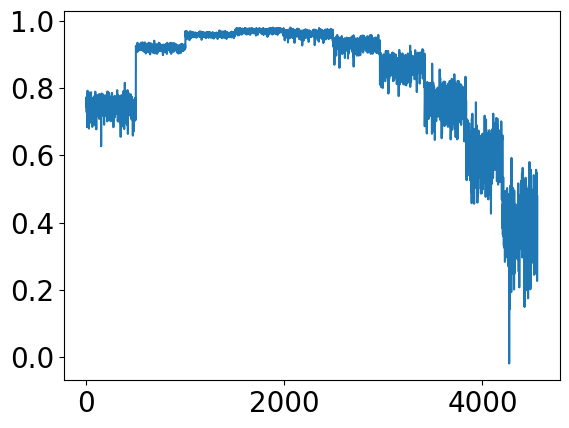

In [25]:
plt.plot(ve.cpu().detach().numpy())

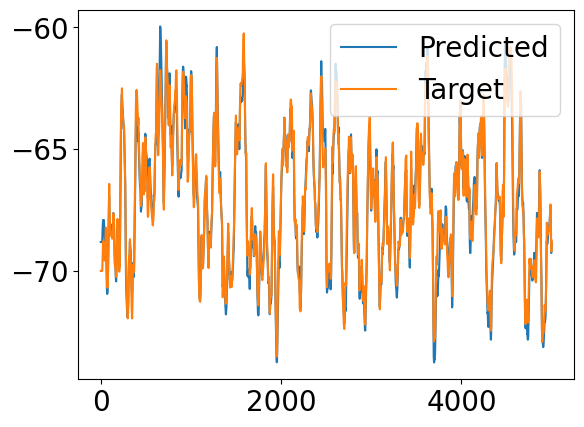

In [26]:
plt.plot(predicted_output[2000].cpu().detach().numpy(), label='Predicted')
plt.plot(train_output[2000].cpu().detach().numpy(), label='Target')
plt.legend()

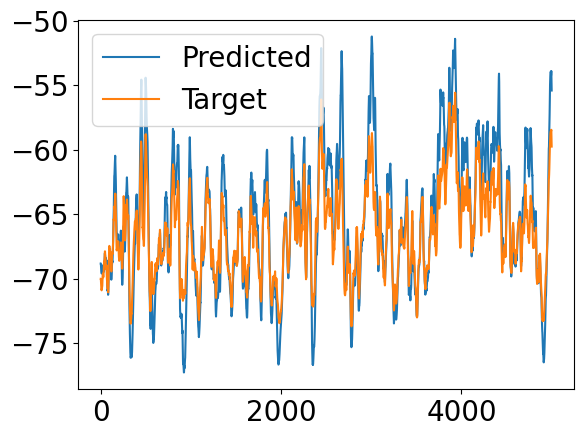

In [27]:
plt.plot(predicted_output[-1].cpu().detach().numpy(), label='Predicted')
plt.plot(train_output[-1].cpu().detach().numpy(), label='Target')
plt.legend()